<a href="https://colab.research.google.com/github/quinhuyn/sql-xss-CNN/blob/main/CNN_detect_sqli%26xss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import glob
import time
import pandas as pd


import os
import matplotlib.pyplot as plt
import keras
from keras.utils import np_utils
import cv2


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
cd /floyd/

/floyd


**DATASET** 252871
- Dataset được trích từ 5 nguồn:
+ [https://github.com/client9/libinjection](https://github.com/client9/libinjection)
+ [https://github.com/das-lab/deep-xss](https://github.com/das-lab/deep-xss)
+ [https://github.com/Morzeux/HttpParamsDataset](https://github.com/Morzeux/HttpParamsDataset)
+ https://www.tic.itefi.csic.es/dataset/
+ https://www.kaggle.com/syedsaqlainhussain/cross-site-scripting-xss-dataset-for-deep-learning


In [ ]:
sql=pd.read_csv('/floyd/input/sqlxssnor/Sql_full.csv')
xss=pd.read_csv('/floyd/input/sqlxssnor/Xss+kaggle_full.csv')
nor=pd.read_csv('/floyd/input/sqlxssnor/Normal_full.csv')

In [ ]:
sql['Label']=2
xss['Label']=1
nor['Label']=0

In [ ]:
sql.head()

,Sentence,Label
0,1' where 6406=6406;select count(*) from rdb$fi...,2
1,1) and 8514=(select count(*) from domain.domai...,2
2,-3136%') or 3400=6002,2
3,1) where 7956=7956 or sleep(5)#,2
4,-7387'))) order by 1--,2


In [ ]:
xss.head()

,Sentence,Label
0,"<tt onmouseover=""alert(1)"">test</tt>",1
1,<a onblur=alert(1) tabindex=1 id=x></a><input ...,1
2,"<col draggable=""true"" ondragenter=""alert(1)"">t...",1
3,<caption onpointerdown=alert(1)>XSS</caption>,1
4,<caption id=x tabindex=1 ondeactivate=alert(1)...,1


In [ ]:
nor.head()

,Sentence,Label
0,id=3,0
1,nombre=Vino+Rioja,0
2,precio=100,0
3,cantidad=55,0
4,B1=A%F1adir+al+carrito,0


In [ ]:
df=pd.concat([sql,xss,nor])
df.reset_index(inplace=True, drop=True)
print(len(df))
df=df.drop_duplicates()
df.reset_index(inplace=True, drop=True)
print("size full dataset: ",len(df))

240670
size full dataset:  240667


In [ ]:
sql=df[df.Label == 2]
print("Số lượng payload sql: ",len(sql))
xss=df[df.Label == 1]
print("Số lượng payload xss: ",len(xss))
nor=df[df.Label == 0]
print("Số lượng payload normal: ",len(nor))

Số lượng payload sql:  89468
Số lượng payload xss:  61418
Số lượng payload normal:  89781


In [ ]:
#df.to_csv ('/content/drive/MyDrive/DATA/dataset/xss&sql.csv',index=None) 

In [ ]:
df.head()

,Sentence,Label
0,1' where 6406=6406;select count(*) from rdb$fi...,2
1,1) and 8514=(select count(*) from domain.domai...,2
2,-3136%') or 3400=6002,2
3,1) where 7956=7956 or sleep(5)#,2
4,-7387'))) order by 1--,2


In [ ]:
print("size ",df.shape)

size  (240667, 2)


In [ ]:
sentences=df['Sentence'].values
sentences[1]

'1) and 8514=(select count(*) from domain.domains as t1,domain.columns as t2,domain.tables as t3) and (4666=4666'

In [ ]:
len(sentences)

240667

In [ ]:
# Convert to ASCII
def convert_to_ascii(sentence):
    sentence_ascii=[]

    for i in sentence: 
            if(ord(i)==8217): # ’  :  8217
                sentence_ascii.append(133)
            if(ord(i)==8221): # ”  :  8221
                sentence_ascii.append(129)      
            if(ord(i)==8220): # “  :  8220
                sentence_ascii.append(130)
            if(ord(i)==8216): # ‘  :  8216
                sentence_ascii.append(131) 
            if(ord(i)==8211): # –  :  8211
                sentence_ascii.append(132)  
        
            if (ord(i)<=128):
                    sentence_ascii.append(ord(i)) 
            else:
                    pass
        
        
    zer=np.zeros((10000))

    for i in range(len(sentence_ascii)):
        zer[i]=sentence_ascii[i]

    zer.shape=(100, 100)


#    plt.plot(image)
#    plt.show()
    return zer

In [ ]:
# send each sentence to be converted to ASCII


arr=np.zeros((len(sentences),100,100))

for i in range(len(sentences)):
    
    image=convert_to_ascii(sentences[i])
    x=np.asarray(image,dtype='float')
    image =  cv2.resize(x, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
    image/=128
    
    arr[i]=image

In [ ]:
print("Input data shape : ", arr.shape)

Input data shape :  (240667, 100, 100)


In [ ]:
# Reshape data for input to CNN
data = arr.reshape(arr.shape[0], 100, 100, 1)

In [ ]:
data.shape

(240667, 100, 100, 1)

In [ ]:
y=df['Label'].values
y[10]

2

In [ ]:
# Split into train/test data
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(data,y, test_size=0.2, random_state=42)

In [ ]:
print("trainX",trainX.shape)
print("testX",testX.shape)

trainX (192533, 100, 100, 1)
testX (48134, 100, 100, 1)


In [ ]:
sql=0
xss=0
nor=0
for i in range(len(trainY)):
    if trainY[i]==1:
        xss+=1
    elif trainY[i]==2:
        sql+=1
    else:
        nor +=1
anomalous= xss+sql
print ("Number of xss in train: ", xss)
print ("Number of sql in train", sql)
print ("Number of anomalous in train: ", anomalous)
print ("Number of normal in train", nor)


sql=0
xss=0
nor=0
for i in range(len(testY)):
    if testY[i]==1:
        xss+=1
    elif testY[i]==2:
        sql+=1
    else:
        nor +=1
anomalous= xss+sql
print ("Number of xss  in test: ", xss)
print ("Number of sql in test", sql)
print ("Number of anomalous in test: ", anomalous)
print ("Number of normal in test", nor)

Number of xss in train:  49297
Number of sql in train 71707
Number of anomalous in train:  121004
Number of normal in train 71529
Number of xss  in test:  12121
Number of sql in test 17761
Number of anomalous in test:  29882
Number of normal in test 18252


In [ ]:
nb_class=3
#one host code
trainY=np_utils.to_categorical(trainY,nb_class)
test_Y=testY
testY=np_utils.to_categorical(testY,nb_class)
#y_test=np_utils.to_categorical(y_test,nb_class)

In [ ]:
# import libraries for Making Model
#import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D,Flatten,Dropout,MaxPool2D, BatchNormalization

In [ ]:
# A basic CNN Model
# Number of layers = 11
# Number of Convolutional layer: 3

model=tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(64,(3,3), activation=tf.nn.relu, input_shape=(100,100,1)),
    tf.keras.layers.MaxPooling2D(2,2),


    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
 

    tf.keras.layers.Conv2D(256,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
 #  tf.keras.layers.Dropout(0.25),
 #  tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
    
])

- Adam: Trình tối ưu hóa triển khai thuật toán Adam.

 + Tối ưu hóa Adam là một phương pháp giảm độ dốc ngẫu nhiên dựa trên ước tính thích ứng của các khoảnh khắc bậc nhất và bậc hai.

 + Theo Kingma và cộng sự, 2014 , phương pháp này " hiệu quả về mặt tính toán, yêu cầu ít bộ nhớ, bất biến với thay đổi tỷ lệ theo đường chéo của gradient và rất phù hợp cho các vấn đề lớn về dữ liệu / tham số ".

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

In [ ]:
#batch_size = 128
#num_epoch = 20
#model training
model_log = model.fit(trainX, trainY,
          batch_size=128,
          epochs=20,
          verbose=1,
          validation_data=(testX,testY)
 #           callbacks=[callbacks]
                     )

Epoch 1/20
1505/1505 [==============================] - 352s 174ms/step - loss: 0.3143 - accuracy: 0.8757 - val_loss: 0.0656 - val_accuracy: 0.9803
Epoch 2/20
1505/1505 [==============================] - 234s 156ms/step - loss: 0.0594 - accuracy: 0.9829 - val_loss: 0.0380 - val_accuracy: 0.9889
Epoch 3/20
1505/1505 [==============================] - 234s 155ms/step - loss: 0.0353 - accuracy: 0.9899 - val_loss: 0.0229 - val_accuracy: 0.9932
Epoch 4/20
1505/1505 [==============================] - 233s 155ms/step - loss: 0.0258 - accuracy: 0.9927 - val_loss: 0.0222 - val_accuracy: 0.9940
Epoch 5/20
 921/1505 [=================>............] - ETA: 1:23 - loss: 0.0216 - accuracy: 0.9937

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1505/1505 [==============================] - 233s 155ms/step - loss: 0.0156 - accuracy: 0.9957 - val_loss: 0.0166 - val_accuracy: 0.9953
Epoch 8/20
1505/1505 [==============================] - 233s 155ms/step - loss: 0.0147 - accuracy: 0.9961 - val_loss: 0.0138 - val_accuracy: 0.9964
Epoch 9/20
1505/1505 [==============================] - 233s 155ms/step - loss: 0.0112 - accuracy: 0.9969 - val_loss: 0.0135 - val_accuracy: 0.9962
Epoch 10/20
1505/1505 [==============================] - 233s 155ms/step - loss: 0.0093 - accuracy: 0.9976 - val_loss: 0.0180 - val_accuracy: 0.9953
Epoch 11/20
1505/1505 [==============================] - 233s 155ms/step - loss: 0.0098 - accuracy: 0.9973 - val_loss: 0.0164 - val_accuracy: 0.9961
Epoch 12/20
1505/1505 [==============================] - 233s 155ms/step - loss: 0.0093 - accuracy: 0.9976 - val_loss: 0.0157 - val_accuracy: 0.9962
Epoch 13/20
1505/1505 [==============================] - 233s 155ms/step - loss: 0.0078 - accuracy: 0.9980 - val_loss: 0

In [ ]:
model.save('/floyd/home/model lan_2')

INFO:tensorflow:Assets written to: /floyd/home/model lan_2/assets


In [ ]:
#model = keras.models.load_model('home/model xss-sql')

In [ ]:
# predict for test set
p=model.predict(testX)

In [ ]:
p[10]

array([3.7830152e-21, 1.0000000e+00, 3.2829111e-18], dtype=float32)

In [ ]:
len(p)

48134

In [ ]:
pred=np.zeros(len(p))
for i in range(len(p)):
    pred[i]=np.argmax(p[i])

In [ ]:
pred[1]

0.0

In [ ]:
# Số dự đoán đúng và sai
truex=0
truen=0
trues=0
false=0
a=0
b=0
c=0
d=0
e=0
f=0
for i in range(len(pred)):
    if pred[i] == test_Y[i] and pred[i]==0:
        truen+=1
    elif pred[i] == test_Y[i] and pred[i]==1:
        truex+=1    
    elif pred[i] == test_Y[i] and pred[i]==2:
        trues+=1
        
    else:
        false+=1
        if test_Y[i]==0:
            if pred[i]==1:
                a+=1
            elif pred[i]==2:
                b+=1
        elif test_Y[i]==1 and pred[i]==0:
            c+=1
        elif test_Y[i]==1 and pred[i]==2:
            d+=1
        elif test_Y[i]==2 and pred[i]==1:
            e+=1
        elif test_Y[i]==2 and pred[i]==0:
            f+=1
print("correct predicted normal :: ", truen)
print("correct predicted xss :: ", truex)
print("correct predicted sql :: ", trues)
print("false prediction :: ", false)
print (a,b,c,e,f)

correct predicted normal ::  18216
correct predicted xss ::  12012
correct predicted sql ::  17734
false prediction ::  172
27 9 86 9 18


In [ ]:
# Số lượng dữ liệu lành tính hay anomalous trong tập test (đã in ở trên r)
attack=0
benign=0
for i in range(len(testY)):
    if test_Y[i]==1 or test_Y[i]==2:
        attack+=1
    else:
        benign+=1

print("Attack data in test set :: ", attack)
print(" Benign data in test set :: ", benign)

Attack data in test set ::  29882
 Benign data in test set ::  18252


In [ ]:
# Takes True positive, true negative, false positive and false negative as input
# Returns Accuracy

def accuracy_function(tp,tn,fp,fn):
    
    accuracy = (tp+tn) / (tp+tn+fp+fn)
    
    return accuracy

In [ ]:
# Takes True Positive and false positive
# Returns Precision

def precision_function(tp,fp):
    
    precision = tp / (tp+fp)
    
    return precision

In [ ]:
#Takes True Positive and false negative
# Returns Recall

def recall_function(tp,fn):
    
    recall=tp / (tp+fn)
    
    return recall

In [ ]:
#Takes true values and predicted
# Returns Accuracy, precision and recall


def confusion_matrix(truth,predicted):
    
    true_positive = 0   #gan TP = 0
    true_negative = 0   #gan TN = 0
    false_positive = 0  #gan FP = 0
    false_negative = 0  #gan FN = 0
    for true,pred in zip(truth,predicted):
        if true == 1 or true == 2:
            if pred == true:
                true_positive += 1
            elif pred != true:
                false_negative += 1

        elif true == 0:
            if pred == true:
                true_negative += 1
            elif pred != true:
                false_positive += 1
    print("TP: ",true_positive)
    print("FN: ",false_negative)
    print("TN: ",true_negative)
    print("FP: ",false_positive)
      
    accuracy=accuracy_function(true_positive, true_negative, false_positive, false_negative)
    precision=precision_function(true_positive, false_positive)
    recall=recall_function(true_positive, false_negative)
 
    return (accuracy,
            precision,
           recall)

In [ ]:
accuracy,precision,recall=confusion_matrix(test_Y,pred)

TP:  29746
FN:  136
TN:  18216
FP:  36


In [ ]:
print("\n Accuracy : {0} \n Precision : {1} \n Recall : {2} ".format(accuracy, precision, recall)) 


 Accuracy : 0.996426642290273 
 Precision : 0.9987912161708414 
 Recall : 0.9954487651428954 


In [ ]:
from sklearn.metrics import f1_score
f1_score_val = f1_score(test_Y, pred, average=None)

In [ ]:
f1_score_micro= f1_score(test_Y, pred, average='micro')

In [ ]:
f1_score_macro=f1_score(test_Y, pred, average='macro')

f1_score_weighted=f1_score(test_Y, pred, average='weighted')

In [ ]:
print("\n f1_score_val: {0} \n f1_score_micro : {1} \n f1_score_macro : {2} \n f1_score_weighted {3}".format(f1_score_val, f1_score_micro, f1_score_macro, f1_score_weighted))


 f1_score_val: [0.99617193 0.99400058 0.99833929] 
 f1_score_micro : 0.996426642290273 
 f1_score_macro : 0.996170601770405 
 f1_score_weighted 0.9964248831830104


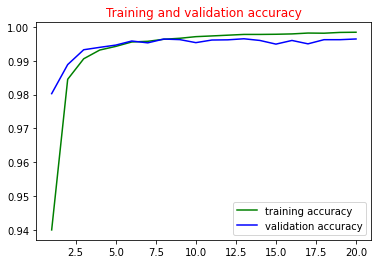

<Figure size 432x288 with 0 Axes>

In [ ]:
# vẽ đồ thị
import matplotlib.pyplot as plt
acc= model_log.history['accuracy']
val_acc = model_log.history['val_accuracy']
loss = model_log.history['loss']
val_loss = model_log.history['val_loss']
epochs= range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training accuracy',c='green')
plt.plot(epochs,val_acc,'b',label='validation accuracy')
plt.title("Training and validation accuracy", c='red')
plt.legend()
plt.figure()
plt.show()

In [ ]:
from sklearn import metrics

# Print the confusion matrix
print(metrics.confusion_matrix(test_Y, pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(test_Y, pred,target_names=['Normal', 'XSS', 'SQL'], digits=3))

[[18216    27     9]
 [   86 12012    23]
 [   18     9 17734]]
              precision    recall  f1-score   support

      Normal      0.994     0.998     0.996     18252
         XSS      0.997     0.991     0.994     12121
         SQL      0.998     0.998     0.998     17761

    accuracy                          0.996     48134
   macro avg      0.997     0.996     0.996     48134
weighted avg      0.996     0.996     0.996     48134



In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_Y, pred)
print('Confusion matrix:')
print(cnf_matrix)

Confusion matrix:
[[18216    27     9]
 [   86 12012    23]
 [   18     9 17734]]


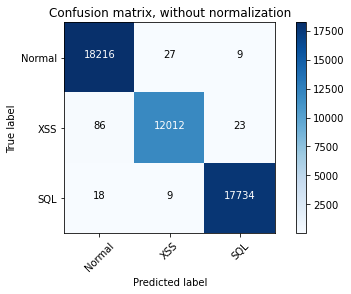

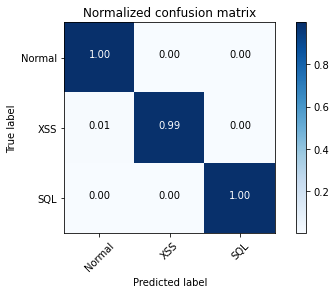

In [ ]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
class_names = ['Normal', 'XSS', 'SQL']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
#confusion = confusion_matrix(testX, pred)
print('Confusion Matrix\n')
#print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.10f}\n'.format(accuracy_score(test_Y, pred)))

print('Micro Precision: {:.10f}'.format(precision_score(test_Y, pred, average='micro')))
print('Micro Recall: {:.10f}'.format(recall_score(test_Y, pred, average='micro')))
print('Micro F1-score: {:.10f}\n'.format(f1_score(test_Y, pred, average='micro')))

print('Macro Precision: {:.10f}'.format(precision_score(test_Y, pred, average='macro')))
print('Macro Recall: {:.10f}'.format(recall_score(test_Y, pred, average='macro')))
print('Macro F1-score: {:.10f}\n'.format(f1_score(test_Y, pred, average='macro')))

print('Weighted Precision: {:.10f}'.format(precision_score(test_Y, pred, average='weighted')))
print('Weighted Recall: {:.10f}'.format(recall_score(test_Y, pred, average='weighted')))
print('Weighted F1-score: {:.20f}'.format(f1_score(test_Y, pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(test_Y, pred, target_names=['Normal', 'XSS', 'SQL']))

Confusion Matrix


Accuracy: 0.9964266423

Micro Precision: 0.9964266423
Micro Recall: 0.9964266423
Micro F1-score: 0.9964266423

Macro Precision: 0.9965113010
Macro Recall: 0.9958382571
Macro F1-score: 0.9961706018

Weighted Precision: 0.9964303175
Weighted Recall: 0.9964266423
Weighted F1-score: 0.99642488318301036809

Classification Report

              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00     18252
         XSS       1.00      0.99      0.99     12121
         SQL       1.00      1.00      1.00     17761

    accuracy                           1.00     48134
   macro avg       1.00      1.00      1.00     48134
weighted avg       1.00      1.00      1.00     48134



In [ ]:
from sklearn.metrics import f1_score
f1_score_val = f1_score(test_Y, pred, average=None)
f1_score_micro= f1_score(test_Y, pred, average='micro')
f1_score_macro=f1_score(test_Y, pred, average='macro')
f1_score_weighted=f1_score(test_Y, pred, average='weighted')


In [ ]:
print("\n f1_score_val: {0} \n f1_score_micro : {1} \n f1_score_macro : {2} \n f1_score_weighted {3}".format(f1_score_val, f1_score_micro, f1_score_macro, f1_score_weighted))


 f1_score_val: [0.99617193 0.99400058 0.99833929] 
 f1_score_micro : 0.996426642290273 
 f1_score_macro : 0.996170601770405 
 f1_score_weighted 0.9964248831830104


In [ ]:
pd.DataFrame(pred).to_csv("/floyd/home/pred1.csv",index=None,header=None)
#c=pd.read_csv('/content/drive/MyDrive/DATA-6/c.csv',header=None)